#### Oppsett - kjør dette først!

In [1440]:
from asrtoolkit import cer, wer
import requests
import mimetypes
import pytesseract
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from symspellpy import SymSpell, Verbosity
import spacy
from spacy.language import Language, Doc
from spacy.tokens import Token
from spacy.symbols import ORTH
import os
import numpy as np
import regex as re

In [541]:
plt.rcParams["figure.figsize"] = [9.0, 15.0]

In [1864]:
img_path = './db60044923000260.jpg'

In [1226]:
fasit = open('./db60044923000260_fasit.txt').read()

In [786]:
auth_token = '266575f8-aad9-457e-8cbf-f1d7223c2a51'

In [787]:
from pathlib import Path
def download_urnid_from_da(urnid: str, destination_directory: str, auth_token: str):
    """
    Download the requested urnid to a specified directory
    Args:
        urnid (str): 16-character urnid
        destination_directory (str): path to directory to download image to
        auth_token (str): DA token to use for downloading
    """
    API_IMAGE_DOWNLOAD = 'https://media.digitalarkivet.no/api/v1/image/{}'
    response = requests.get(f'{API_IMAGE_DOWNLOAD.format(urnid)}.jpg', headers={'auth-token': auth_token})
    extension = mimetypes.guess_extension(response.headers['Content-Type'].split(';')[0])
    destination_directory = Path(destination_directory)
    destination_directory.mkdir(exist_ok=True)
    output_file_path = (destination_directory / urnid).with_suffix(extension)
    with open(output_file_path, 'wb') as f:
        f.write(response.content)
    return str(output_file_path)

## Del 1:
Definer funksjonen `ocr_file`:

In [1968]:
def find_contours(img_path: str) -> np.ndarray:
    """
    Finner den største rektangulære konturen i bildet og returnerer et beskåret bilde (hvis mulig). 
    Jeg endte opp med å ikke bruke denne funksjonen da jeg lagde korpuset, fordi den ikke alltid klarte
    å beskjære bildene helt riktig.
    """
    
    im = cv2.imread(img_path)
    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(imgray, 200, 255, 0)[1]
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(4,10))
    opened = cv2.morphologyEx(255 - thresh, cv2.MORPH_DILATE, kernel, iterations=9)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,2))
    erode = cv2.morphologyEx(opened, cv2.MORPH_OPEN, kernel, iterations=15)
    
    thresh_copy = thresh.copy()
    contours, hierarchy = cv2.findContours(255 - erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(thresh_copy, contours, -1, (0, 255, 0), 2, cv2.LINE_AA)

    contour_areas = []
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = cv2.contourArea(cnt)
        contour_areas.append((area, x, y, w, h))

    sorted_contours = sorted(contour_areas, key=lambda x: x[0], reverse = True)
    
    try:
        largest_cnt_area, x, y, w, h = sorted_contours[0]
        assert x < 150 and y < 150 and w > 1000
    except: 
        return thresh
    
    # Cropping the text block for giving input to OCR
    cropped = thresh[y: y + h, x: x + w]
    #crop_display = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
    #plt.imshow(crop_display)
    #plt.show()
    
    return cropped

In [1970]:
def ocr_file(img_path: str) -> str:
    
    # Konvertere til svart-hvitt
    image = cv2.imread(img_path)
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    thresholded = cv2.threshold(grayscale, 210, 255, cv2.THRESH_TOZERO)[1]
    
    data = pytesseract.image_to_string(thresholded, lang='nor', config='--psm 6')
    
    return data

Kjør disse cellene for å evaluere:

In [1971]:
contours = find_contours(img_path)

In [1972]:
ocr_result = ocr_file(img_path)

In [1973]:
print(ocr_result)

, ;
te | 3
rebostats tarritorium, alik at å=t internasjonal= organ
ved lov gis myndighet endog innen det norske rikes grenser.
Jeg antar at man ved tolkinger av Grl.?s $ I ikke
kormer utenom en viss inflytelse av de tradisjonelle fokke-
rettslige suverenitstsforestillinger og de historisk-
tradisjonelle inndelinrer av statenes irnbyrdes forhold å
statsrettslige og folkerettsligeforbindelser alt etter
hviiket formelt gyldighetsgrunnlag da= har. Det er nemlig
åpenbart at grunnloven må forutsette en vidtgående adgang
for Norge til å påta sag forkerettslige forpliktelsar som
nödvendigvis må begrense landets handlefrihet. Og rår det
gjelder forpliktelser og forbindelser som tradisjonelt har
vært ansett som folkerettslige ( og fölgelig fornilde -
begrepsmessig - suveranitetsbavarende i forkerettslig
forstand) er dt naturlig å anta at grunnloven tillater
större innskrenkkingøtr handlafrihetan enr når det gjelder
forplirtelser og rorbinsiese, tradisjonelt har vært
Adra sender
reknet for å værs

In [1974]:
print(f'character error rate: {cer(fasit, ocr_result)}\nword error rate: {wer(fasit, ocr_result)}')

character error rate: 6.950028719126939
word error rate: 24.137931034482758


### Post-prosessering av resultatet
Vi får en relativt grei character error rate, men ser at noen tegn ofte har blitt feiloppfattet av OCR-en. Jeg tester en enkel stavekontroll for å få ordnet opp i de mest åpenbare feilene: 

In [1889]:
def load_spell_checker(max_edit_distance: int = 2) -> SymSpell:
    sym_spell = SymSpell(max_dictionary_edit_distance=max_edit_distance, prefix_length=5)
    dict_path = "dictionaries/nb/nasjonalbib_frekvenser_minfreq3_alnum.txt"
    sym_spell.load_dictionary(dict_path, 0, 1, encoding='utf-8')
    
    return sym_spell

In [1890]:
def correct_hyphen_split_subwords(token: Token, doc: Doc, spell: SymSpell):
    def _back_to_old_split(corrected_word: str, first_part: str, second_part: str):
        # Få tilbake delingen av et ord slik den sto i teksten, f. eks. "jordbruket" -> ["jordbru-", "ket"]
        # jordbri-set -> jordbru-ket
        if first_part in corrected_word:
            split_point = len(first_part)
        elif second_part in corrected_word:
            split_point = len(corrected_word) - len(second_part)
        else: 
            split_point = len(first_part)
        parts = [corrected_word[:split_point] + '-', corrected_word[split_point:]]
        return parts
    
    tokens_to_correct = [token.text]
    end_index = token.i
    
    # Samle alle tokens som hører til uttrykket, f. eks. "jaordbruks- organisasjoner"
    for tok in doc[token.i + 1:]:
        tokens_to_correct.append(tok.text)
        if tok.text.isalnum():
            end_index = tok.i # Vi vil beholde indeksen som markerer slutten av uttrykket
            break
    
    first_part = tokens_to_correct[0].replace('-', '')
    second_part = tokens_to_correct[-1]
    full_word = first_part + second_part
    
    corrections = spell.lookup(full_word, Verbosity.TOP)
    
    if corrections: 
        corrected_word = corrections[0].term
        
        if not corrected_word == full_word:
            # Vi deler ordet tilbake omtrent der det var delt, for å beholde mest mulig av strukturen
            final_parts = _back_to_old_split(corrected_word, first_part, second_part)
            
            # Bytt ut de opprinnelige delene med de korrigerte delene
            tokens_to_correct[0] = final_parts[0]
            tokens_to_correct[-1] = final_parts[1]

    return tokens_to_correct, end_index
            

In [1891]:
def post_ocr_correction(text: str, nlp: Language, spell: SymSpell) -> str: 
    
    # Tokeniser teksten med noen unntak for ord med tegnsetting inni, som "forpli:telser"
    for word in text.split():
        if word[-1] not in '!?,:–.-()' and not word.isalpha():
            nlp.tokenizer.add_special_case(word, [{ORTH: word}])
    doc = nlp.make_doc(text)
    
    corrected_text = ''
    
    i = 0
    
    # Går gjennom tokens fra teksten med stavekontrollen og korrigerer
    while i < len(doc):
        
        token = doc[i]
        i += 1
        
        # Hvis token er whitespace, legg den til i korrigert versjon og gå videre
        if token.text.isspace():
            corrected_text += token.text_with_ws
            continue
        
        # For enkelhetens skyld prøver vi ikke å korrigere tegnsetting eller tall
        if token.is_punct or token.is_digit or any(char.isdigit() for char in token.text):
            corrected_text += token.text_with_ws
            continue
            
        # § blir ofte lest inn som $
        if token.text == '$':
            corrected_text += '§' + token.whitespace_
            continue
        
        # Spacys tokenizer får ikke alltid delt opp all tegnsetting, så vi sjekker om noe har blitt igjen
        if token.text[-1] in '.,!?':
            word_to_look_up = token.text[:-1]
        else: 
            word_to_look_up = token.text
            
        # Vi må spesialhåndtere ord som deles med bindestrek ved linjeskift
        if token.text[-1] in '-–': 
            corrected_tokens, end_index = correct_hyphen_split_subwords(token, doc, spell)
            
            # Vi legger til alle delene av ordet/uttrykket vi har korrigert, med mellomrom på slutten om nødvendig
            for t in corrected_tokens:
                if t == corrected_tokens[-1]:
                    corrected_text += t + doc[end_index].whitespace_
                else:
                    corrected_text += t
            
            # Vi hopper til det neste ordet etter slutten av uttrykket vi nettopp håndterte
            i = end_index + 1
            continue
            
        corrections = spell.lookup(word_to_look_up, Verbosity.TOP)
        
        # For enkelhetens skyld velger vi det første og beste alternativet fra stavekontrollen
        if corrections:
            correction = corrections[0].term
            
            if token.whitespace_: # Hvis det opprinnelige ordet hadde mellomrom etter seg, legg til whitespace
                corrected_word = correction + token.whitespace_ 
            else:
                corrected_word = correction
                
            corrected_text += corrected_word
        else:       
            corrected_text += token.text_with_ws 
        
    return corrected_text

In [1850]:
# Laster spacy-modell og stavekontroll
nlp = spacy.load('nb_core_news_lg')
spell = load_spell_checker(max_edit_distance=2)

In [1975]:
corrected_ocr_result = post_ocr_correction(ocr_result, nlp, spell)

In [1976]:
print(corrected_ocr_result)
print(fasit)

, ;
te i 3
nabostats territorium, slik at åt internasjonale organ
ved lov gis myndighet endog innen det norske rikes grenser.
Jeg antar at man ved tolkinger av Grl.?s § I ikke
kommer utenom en viss inflytelse av de tradisjonelle folke-
rettslige suverenitstsforestillinger og de historisk-
tradisjonelle inndelinger av statenes innbyrdes forhold å
statsrettslige og folkerettsligeforbindelser alt etter
hvilket formelt gyldighetsgrunnlag da har. Det er nemlig
åpenbart at grunnloven må forutsette en vidtgående adgang
for Norge til å påta sag folkerettslige forpliktelsar som
nødvendigvis må begrense landets handlefrihet. Og rår det
gjelder forpliktelser og forbindelser som tradisjonelt har
vært ansett som folkerettslige ( og følgelig forbilde -
begrepsmessig - suveranitetsbavarende i folkerettslig
forstand) er dt naturlig å anta at grunnloven tillater
större innskrenkkingøtr handlefriheten enr når det gjelder
forpliktelser og rorbinsiese, tradisjonelt har vært
Adra sender
reknet for å værs E

In [1977]:
print(f'character error rate: {cer(fasit, corrected_ocr_result)}\nword error rate: {wer(fasit, corrected_ocr_result)}')

character error rate: 6.605399195864446
word error rate: 21.839080459770116


Vi ser at stavekontrollen i postprosesseringen gir oss en marginalt bedre CER og en bedre WER.

## Del 2
Filen 127588_urnids.txt er en liste over urnid-er, eller pekere til bildefiler. Disse kan brukes opp mot API-et til Digitalarkivet for å hente ut bilder med funksjonen `download_urnid_from_da`, som du har fått i starten. Funksjonen tar inn en urnid og returnerer banen som bildet er lastet ned til.

In [1099]:
urnids = open('./127588_urnids.txt').read().split('\n')

In [ ]:
for urnid in urnids:
    download_path_for_image = download_urnid_from_da(urnid, './images', auth_token)
    print(download_path_for_image)

Bruk denne listen sammen med `download_urnid_from_da`, som du fikk, og `ocr_file`, som du har definert, til å lage et korpus over alle dokumentene i denne kilden. Kjør noe NLP på dette som du mener kan være interessant.

### Det grunnleggende først: et korpus som linker bilder med tilhørende (OCR-leste) tekster

In [1892]:
import tqdm

In [1893]:
# NB! Denne tar lang tid å kjøre!
img_dir = './images'
corpus_dir = './av_doc_corpus'

for urnid in tqdm.tqdm(urnids): 
    img_path = os.path.join(img_dir, f'{urnid}.jpg')
    
    ocr_text = ocr_file(img_path)
    corrected_ocr_text = post_ocr_correction(ocr_text, nlp, spell)
    
    data = {
        'urnid': urnid, 
        'img_path': img_path, 
        'raw_ocr_text': ocr_text,
        'corrected_ocr_text': corrected_ocr_text
    }
    
    save_path = os.path.join(corpus_dir, f'{urnid}.json')
    
    with open(save_path, 'w', encoding='utf-8') as outfile:
        json.dump(data, outfile, indent=4)

100%|█████████████████████████████████████████| 756/756 [35:07<00:00,  2.79s/it]


### Deretter: Litt NLP som kan være nyttig/spennende
Selv om noe av teksten vi har fått ut fortsatt er litt rotete, hadde det vært spennende å se hva vi kan gjøre med den. Det første som falt meg inn var å hente ut viktige innholdsord/nøkkelord fra tekstene, som for eksempel kan brukes når man skal søke opp dokumentene. La oss se hva vi finner: 

In [1894]:
# Vi holder styr på hele korpuset i en dictionary sånn at vi kan lage en versjon av korpuset 
# til slutt som inneholder alt vi har funnet.
full_corpus = {}

#### Innholdsord

In [1895]:
# Når vi henter ut tokens/innholdsord vil vi forsikre oss om at vi bare bruker ord som faktisk finnes, siden
# tekstene våre er litt rotete.
valid_words = {}
with open('./dictionaries/nb/nasjonalbib_frekvenser_minfreq3_alnum.txt', 'r') as infile:
    for line in infile:
        word, freq = line.split()
        if int(freq) > 50:
            valid_words[word] = int(freq)

In [1896]:
# Mønster for å oppdage bindestrek + linjeskift
re_pattern = re.compile(r'-\s+')

for i, urnid in enumerate(urnids): 
    filepath = os.path.join(corpus_dir, f'{urnid}.json')
    
    with open(filepath, 'r', encoding='utf-8') as infile: 
        data = json.load(infile) 
        
    corrected_ocr_text = data['corrected_ocr_text']
    
    # En liten vask av ord som deles med bindestrek + linjeskift
    cleaned_text = re.sub(re_pattern, '', corrected_ocr_text)
    
    # Vi lar spacy analysere teksten
    doc = nlp(cleaned_text)
    
    content_words = [(token.lemma_.lower(), token.i) for token in doc 
                     if token.pos_ in ['PROPN', 'ADJ', 'NOUN'] 
                     and token.lemma_.lower() in valid_words 
                     and len(token.lemma_) > 3 
                     and token.text.isalpha()]
    
    unique_content_words = np.unique([tup[0] for tup in content_words]).tolist()
    
    # Vi printer de første resultatene for å inspisere
    if i < 3:
        print(urnid)
        print(content_words)
        print(unique_content_words)
        
    # Vi tar med oss tokeniserte versjoner av teksten til senere bruk
    tokens = [token.text for token in doc]
    lemmatized_tokens = [token.lemma_ for token in doc]
    
    data['cleaned_text'] = cleaned_text
    data['tokens'] = tokens
    data['lemmatized_tokens'] = lemmatized_tokens
    data['content_words'] = content_words
    data['unique_content_words'] = unique_content_words
    full_corpus[urnid] = data
    

db60044923000001
[('riksarkivet', 12), ('arkiv', 18), ('justisdepartementet', 22), ('lovavdelingen', 26), ('serie', 32), ('emne', 42), ('statsrett', 47), ('forvaltningsrett', 49), ('innhold', 55), ('grunnloven', 61), ('tappe', 66), ('forståelse', 78), ('mappe', 83)]
['arkiv', 'emne', 'forståelse', 'forvaltningsrett', 'grunnloven', 'innhold', 'justisdepartementet', 'lovavdelingen', 'mappe', 'riksarkivet', 'serie', 'statsrett', 'tappe']
db60044923000002
[]
[]
db60044923000003
[('forbindelse', 8), ('bestemmelse', 10), ('utkast', 12), ('avtale', 17), ('bestemmelse', 19), ('henhold', 24), ('vedtak', 31), ('stortinget', 33), ('pristilskudd', 39), ('stortinget', 49), ('nødvendig', 56), ('bevilgning', 57), ('paragraf', 61), ('uttrykkelig', 65), ('bestemmelse', 69), ('avtale', 71), ('hjemmel', 82), ('gyldig', 89), ('forskrift', 90), ('oppmerksomhet', 96), ('adgang', 103), ('opptatt', 107), ('forhandling', 108), ('endring', 110), ('løpende', 114), ('avtale', 115), ('omstendighet', 119), ('avtale

Vi har fått opp noen innholdsord her, men vi kan ha lyst til å trekke ut fraser også. La oss se på noen enkle fraser med spacys matcher-funksjon: 

In [1897]:
from spacy.matcher import Matcher

# Vi lager noen enkle mønstre som kan plukke opp veldig enkle nomenfraser
adj_noun_pattern = [{"POS": "ADJ"}, {"POS": "NOUN"}]
noun_noun_pattern = [{"POS": "NOUN"}, {"POS": "NOUN"}]

matcher = Matcher(nlp.vocab)
matcher.add('Adj_noun', [adj_noun_pattern])
matcher.add('Noun_noun', [noun_noun_pattern])

In [1898]:
for i, urnid in enumerate(urnids): 
    
    data = full_corpus[urnid]
    text = data['cleaned_text']
    
    # Vi lar spacy analysere teksten
    doc = nlp(text)
    
    noun_phrases = matcher(doc)
    
    phrases = []
    # Vi printer bare de første resultatene for å inspisere
    if i < 3:
        print(urnid)
        for match_id, start, end in noun_phrases:
            span = doc[start:end]  # The matched span
            print(start, end, span.text)
    else:
        break


db60044923000001
6 8 fu jr
db60044923000002
db60044923000003
7 9 derne forbindelse
12 14 utkastets §
39 41 pristilskudd sor
56 58 nødvendige bevilgninger
89 91 gyldig forskrift
95 97 videre oppmerksomheten
107 109 opptatt forhandlinger
114 116 løpende avtale
129 131 rye forhandlinger
145 147 vesentlige endringer
158 160 ferdbrukete 1eni
159 161 1eni ninger
162 164 Nærmere reglar
166 168 endringer skål
174 176 utslagene størrelse
177 179 beregning måten
202 204 ordinære forhandlinger
226 228 løpende avtale
249 251 løpende avtale
259 261 endrete forhold
290 292 lengere tidsrom
316 318 12. juli
319 321 förste avsnitt
320 322 avsnitt 1.f


#### Named Entity Recognition (NER)
En annen, litt spissere måte å finne nøkkelord/viktige fraser kan være NER. Her får vi ikke bare ut fraser/navn/ord som er viktige, men vi får også en antatt kategori for hver frase vi henter ut. 

In [1902]:
from spacy import displacy 

for i, urnid in enumerate(urnids):
    text = full_corpus[urnid]['cleaned_text']

    doc = nlp(text) 
    
    entities = []
    
    # Printer en for å inspisere
    if i == 2: 
        displacy.render(doc, style='ent', jupyter=True)
    
    for ent in doc.ents:
        
        entity_info = {
            'name': ent.text,
            'start': ent.start, 
            'end': ent.end,
            'ent_type': ent.label_
        }
        
        entities.append(entity_info)
    
    full_corpus[urnid]['cleaned_text_entities'] = entities

#### LDA
Vi har trukket ut både innholdsord og noen enkle fraser, men alene er de litt intetsigende. La oss se om vi kan trekke ut noen temaer (topics) fra tekstene. Her bruker jeg LDA for å se om vi får ut noen interessante temaord. 

In [1903]:
from pprint import pprint
from gensim.models import LdaModel, TfidfModel
import gensim.corpora as corpora
from stop_words import get_stop_words
nor_stopwords = get_stop_words('norwegian')

In [1904]:
def preprocess_tokens(raw_tokens: list[str], stopwords: list[str]):
    final_tokens = []
    # Vi bruker bare tokens som er alfabetiske (ingen tall/andre tegn) og som ikke er veldig korte,
    # da de korte ordene ofte er ikke-ord eller stoppord. 
    for token in raw_tokens: 
        if token not in stopwords:
            final_tokens.append(token.lower()) 
    return final_tokens

In [1905]:
preprocessed_documents = []
added_urnids = []

for i, urnid in enumerate(urnids): 
    # Vi bruker bare innholdsord fordi det er disse som er mest relevante
    content_words = [token_tup[0] for token_tup in full_corpus[urnid]['content_words']]
    preprocessed_tokens = preprocess_tokens(content_words, nor_stopwords)
    
    # Vi printer de første for å inspisere
    if i < 3:
        print(preprocessed_tokens)
        
    # Til LDA vil vi bare ha dokumenter som har litt innhold, så vi dropper dokumenter som er veldig korte
    if len(preprocessed_tokens) > 5:
        preprocessed_documents.append(preprocessed_tokens)
        added_urnids.append(urnid)

['riksarkivet', 'arkiv', 'justisdepartementet', 'lovavdelingen', 'serie', 'emne', 'statsrett', 'forvaltningsrett', 'innhold', 'grunnloven', 'tappe', 'forståelse', 'mappe']
[]
['forbindelse', 'bestemmelse', 'utkast', 'avtale', 'bestemmelse', 'henhold', 'vedtak', 'stortinget', 'pristilskudd', 'stortinget', 'nødvendig', 'bevilgning', 'paragraf', 'uttrykkelig', 'bestemmelse', 'avtale', 'hjemmel', 'gyldig', 'forskrift', 'oppmerksomhet', 'adgang', 'opptatt', 'forhandling', 'endring', 'løpende', 'avtale', 'omstendighet', 'avtale', 'grunnlag', 'krav', 'forhandling', 'mangel', 'bestemmelse', 'avtale', 'vesentlig', 'endring', 'pris', 'jordbruk', 'driftsmiddel', 'ning', 'nærmere', 'reglar', 'endring', 'skål', 'vesentlig', 'utslag', 'størrelse', 'beregning', 'måte', 'justeringsforhandlingene', 'øvrig', 'regel', 'ordinær', 'forhandling', 'vilkår', 'krav', 'opptagelse', 'forhandling', 'endring', 'løpende', 'avtale', 'stede', 'part', 'enighet', 'myndighet', 'endring', 'løpende', 'avtale', 'grunn', 'f

In [1906]:
id2word = corpora.Dictionary(preprocessed_documents)

In [1907]:
corpus = [id2word.doc2bow(doc) for doc in preprocessed_documents]
print(len(corpus))

687


In [1908]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

Nå har vi gjort klart tekstene ved å preprossesere dem og lage BOW- og TF-IDF-representasjoner av dokumentene. Vi kan snart lage LDA-modellen. Det er ikke alltid lett å velge antall topics, så vi kjører en liten koherenstest først. 

In [1909]:
from gensim.models import CoherenceModel
import pandas as pd
import seaborn as sns

<AxesSubplot:xlabel='Antall temaer', ylabel='Koherens-score'>

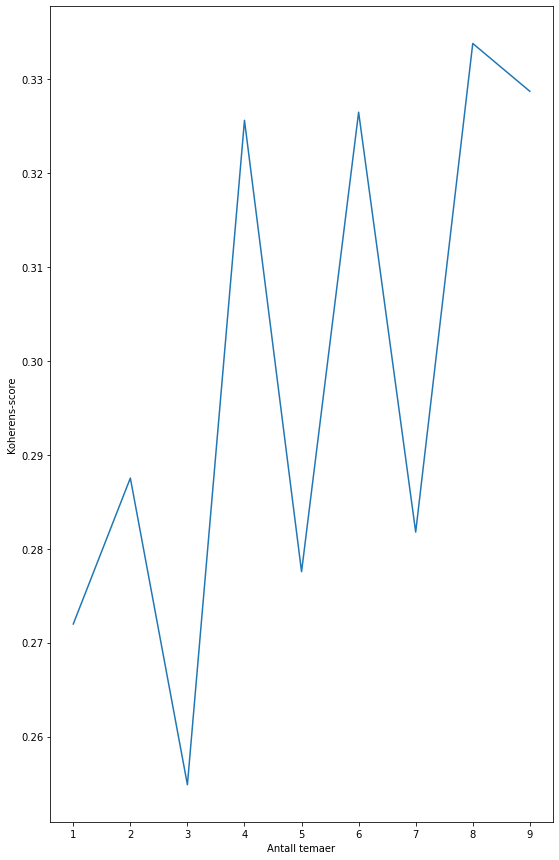

In [1913]:
num_topics = []
coherence_score = []

for i in range(1,10):
    lda_model = LdaModel(corpus=corpus_tfidf,
                         id2word=id2word,
                         iterations=50,
                         num_topics=i)
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                         texts=preprocessed_documents, 
                                         corpus=corpus_tfidf,
                                         dictionary=id2word, 
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    num_topics.append(i)
    coherence_score.append(coherence_lda)

# Vi lager en dataframe for å printe resultatene
topic_coherence = pd.DataFrame({'Antall temaer':num_topics,
                                'Koherens-score':coherence_score})

# Print a line plot
sns.lineplot(data=topic_coherence, x='Antall temaer', y='Koherens-score')

Koherensen svinger med antall topics, men num_topics=8 gir høyest score på denne grafen. Vi prøver med num_topics=8. La oss lage modellen og se på hvilke topics vi får ut.

In [1914]:
num_topics = 8

lda_model = LdaModel(corpus=corpus_tfidf,
                     id2word=id2word,
                     num_topics=num_topics)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.002*"overskjønn" + 0.002*"sorenskriver" + 0.001*"erstatning" + '
  '0.001*"ålesund" + 0.001*"alternativ" + 0.001*"stat" + 0.001*"eiendom" + '
  '0.001*"grunn" + 0.001*"ekspropriasjon" + 0.001*"havnevesen"'),
 (1,
  '0.002*"post" + 0.001*"jordbruk" + 0.001*"avtale" + 0.001*"embetsmann" + '
  '0.001*"stat" + 0.001*"pris" + 0.001*"stilling" + 0.001*"land" + '
  '0.001*"utvalg" + 0.001*"grunn"'),
 (2,
  '0.002*"grunnloven" + 0.001*"post" + 0.001*"bevilgning" + 0.001*"erstatning" '
  '+ 0.001*"stortinget" + 0.001*"vinmonopolet" + 0.001*"forslag" + '
  '0.001*"norsk" + 0.001*"side" + 0.001*"stat"'),
 (3,
  '0.001*"politi" + 0.001*"pastor" + 0.001*"konstitusjon" + 0.001*"komiteen" + '
  '0.001*"pris" + 0.001*"forhold" + 0.001*"uttalelse" + 0.001*"virksomhet" + '
  '0.001*"utvalg" + 0.001*"jordbruk"'),
 (4,
  '0.002*"regjering" + 0.001*"stat" + 0.001*"avtale" + 0.001*"stortinget" + '
  '0.001*"forslag" + 0.001*"rett" + 0.001*"post" + 0.001*"formue" + '
  '0.001*"bevilgning" + 0.001*"

Ut ifra koherensgrafen vi så tidligere og resultatene vi ser her, er det tydelig at det er mange overlappende temaer i denne samlingen av tekster (mange av tekstene handler om de samme tingene). La oss se på noen individuelle dokumenter: 

In [1915]:
for i, urnid in enumerate(added_urnids[2:4]):
    tfidf_doc = corpus_tfidf[i]
    print(full_corpus[urnid]['corrected_ocr_text'])
    for index, score in sorted(lda_model[tfidf_doc], key=lambda tup: -1*tup[1]):
        print("\nScore: {}\t \nTema: {}".format(score, lda_model.print_topic(index, 10)))

bestemmelser. I det nye utkast står bare tilbake en bestem-
melse 6€$ 11) om at den fordel som ja bruket kan skaffe seg
gjennom: øket produksjon og rasjonalisme: ing av gårdsdriften,
omsetningen og foredlingen ved oppsettingen av de kortsiktige
prisavtaler så vidt mulig under hensyntagen til landets økono-
miske mi vil komme jordbruket til gode. LDenne bestemmelse

er tvetydig. Det er å foretrekke at ordene så vidt mulig
settes etter under hensyntagen til landets økonomi.":.

Bestemmelser i det tidligere utkasts avsnitt III om til-
tak for å regulere markedet og sikre avsetningen av jordbru-
kets produkter er som nevnt heller ikke kommet med i det nye
utkast.

Det nye utkast fastslår at priser på jordbrukets salgs-
varer og ariftsmifilger först skal fastsettes etter forutgående
forhandlinger. mellom statsmyndighetens og de to jordbruks-
organisasjoner i 1). Likeledes han forhandlinger etter § 6
kreves opptatt com andre regulerende tiltak. Blir enighet opp-

rådd, skal etter § 7 prismyn

La oss nå gå gjennom hele korpuset og lagre temaord for hver tekst. 

In [1916]:
for i, urnid in enumerate(added_urnids):
    
    tfidf_doc = corpus_tfidf[i]
    topic_results = lda_model.get_document_topics(tfidf_doc, minimum_probability=0.2)
    
    topics_detected = []
    
    for result in topic_results:
       
        topic_index = result[0]
        topic_score = result[1]
        
        topic_terms = [tup[0] for tup in lda_model.show_topic(topic_index, topn=10)]
        
        topic_data = {
            'index': topic_index,
            'score': str(topic_score), # Fordi floats ikke kan serialiseres som JSON
            'terms': topic_terms
        }
        
        topics_detected.append(topic_data)
        
    full_corpus[urnid]['lda_topic'] = topics_detected

Nå har vi lagt til litt ekstra data i korpuset vårt i form av nøkkelord/innholdsord og mer "abstrakte" emneord. La oss lagre en ny versjon av korpuset med disse tilleggsdataene!

In [1918]:
save_dir = './av_doc_corpus_keywords'

for urnid, data in full_corpus.items():
    
    save_path = os.path.join(save_dir, f'{urnid}.json')
    
    with open(save_path, 'w', encoding='utf-8') as outfile:
        json.dump(data, outfile, indent=4)
    